In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from lstm_policy import pad_and_concat
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF

In [3]:
np.set_printoptions(precision=2, suppress=True)

In [4]:
import tensorflow as tf

BATCH_SIZE = 64

sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('models/activepolicy-18-03-20-103135/model-100000064.meta')
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint('./models/activepolicy-18-03-20-103135/.'))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from ./models/activepolicy-18-03-20-103135/./model-100000064


In [5]:
g_inputs = graph.get_tensor_by_name("inputs:0")
g_lengths = graph.get_tensor_by_name("lengths:0")

In [6]:
g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [7]:
np.set_printoptions(precision=3, suppress=True)

In [8]:
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])

1.0 [1.    0.999 1.    1.    1.    1.    1.    1.   ]


In [9]:
# Because we have to pass full batch

logfile = open("/tmp/log", "w")

class LSTMBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        cnfs = [input_cnf] * BATCH_SIZE
        cnfs_clauses = [[claus + tuple([claus[0]] * (3-len(claus))) for claus in cnf.clauses] for cnf in cnfs]
        inputs, lengths = pad_and_concat(cnfs_clauses)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs, g_lengths: lengths})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', cnfs_clauses[0], end=' ', file=logfile)
        print("probs:",  policy_probs[0], end=' \n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][(var-1)*2 + (0 if svar > 0 else 1)]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [10]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    for sat in sats:
        dpll = dpll_cls()
        res = dpll.run(sat)
        assert res is not None
        steps.append(dpll.number_of_runs)
        errors.append(dpll.number_of_errors)
    return steps, errors

In [11]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [12]:
def print_all(s, k, n, m):
    global S, K, N, M
    S = s
    K = k
    N = n
    M = m
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_random_kcnf(K, N, M)
        if DPLL().run(sat) is not None:
            sats.append(sat)
    assert len(sats) == S
    compute_and_print_steps(sats, DPLL)
    compute_and_print_steps(sats, RandomVarDPLL)
    compute_and_print_steps(sats, RandomClauseDPLL)
    compute_and_print_steps(sats, LSTMBasedDPLL)
    compute_and_print_steps(sats, MostCommonVarDPLL)
    logfile.flush()

#Sats: 400; avg step: 3.76; stdev step: 1.22; avg error: 0.67; stdev error: 0.67


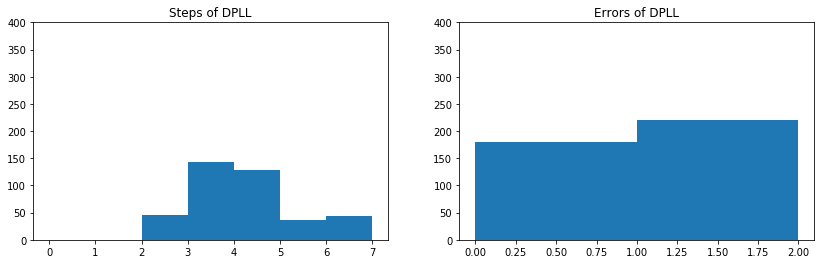

#Sats: 400; avg step: 3.77; stdev step: 1.21; avg error: 0.65; stdev error: 0.63


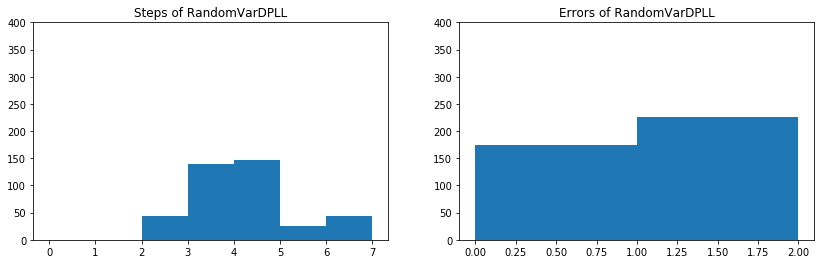

#Sats: 400; avg step: 3.02; stdev step: 0.82; avg error: 0.16; stdev error: 0.37


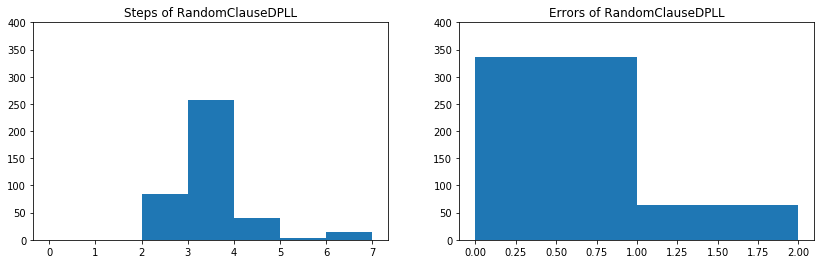

#Sats: 400; avg step: 2.83; stdev step: 0.38; avg error: 0.00; stdev error: 0.00


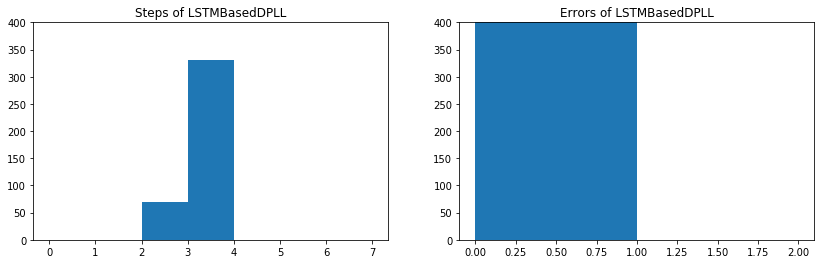

#Sats: 400; avg step: 2.67; stdev step: 0.50; avg error: 0.01; stdev error: 0.12


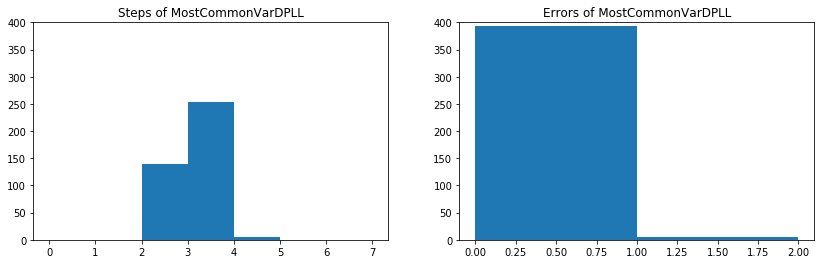

In [13]:
print_all(400, 2, 2, 3)

#Sats: 400; avg step: 4.46; stdev step: 1.58; avg error: 0.70; stdev error: 0.67


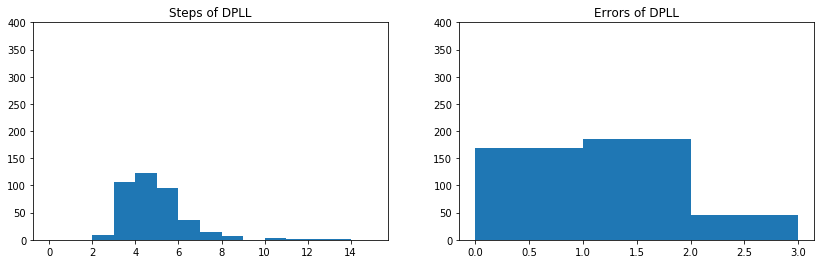

#Sats: 400; avg step: 4.47; stdev step: 1.59; avg error: 0.71; stdev error: 0.69


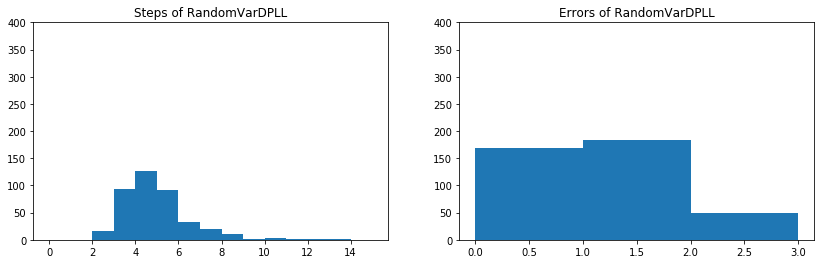

#Sats: 400; avg step: 3.23; stdev step: 0.74; avg error: 0.08; stdev error: 0.28


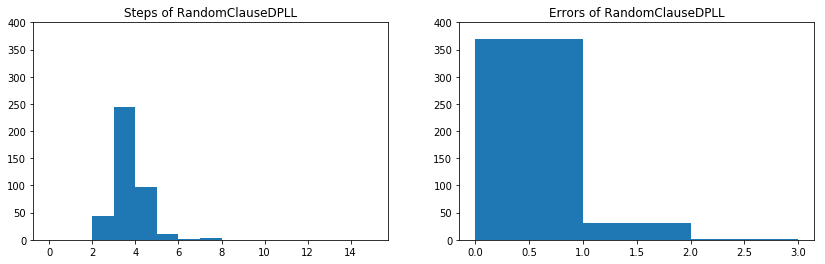

#Sats: 400; avg step: 3.35; stdev step: 0.57; avg error: 0.00; stdev error: 0.00


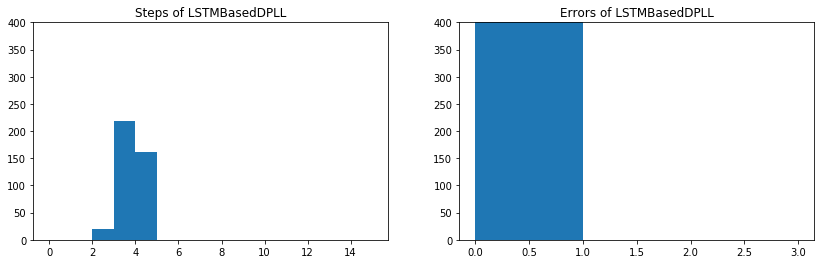

#Sats: 400; avg step: 2.93; stdev step: 0.56; avg error: 0.02; stdev error: 0.13


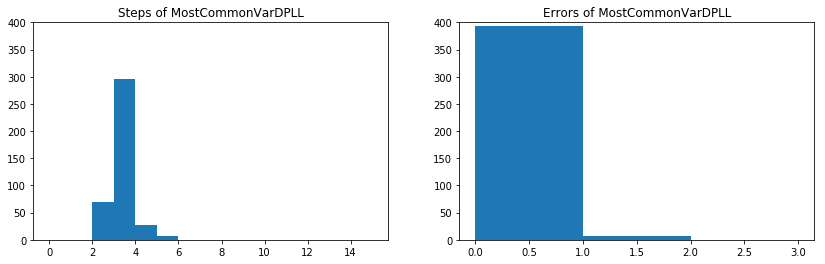

In [14]:
print_all(400, 2, 3, 3)

#Sats: 400; avg step: 5.06; stdev step: 1.96; avg error: 0.71; stdev error: 0.72


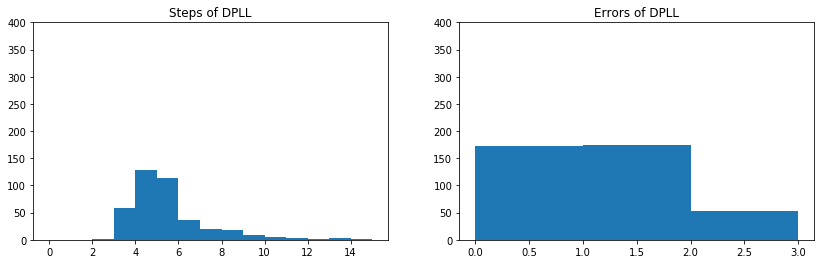

#Sats: 400; avg step: 4.97; stdev step: 1.81; avg error: 0.69; stdev error: 0.69


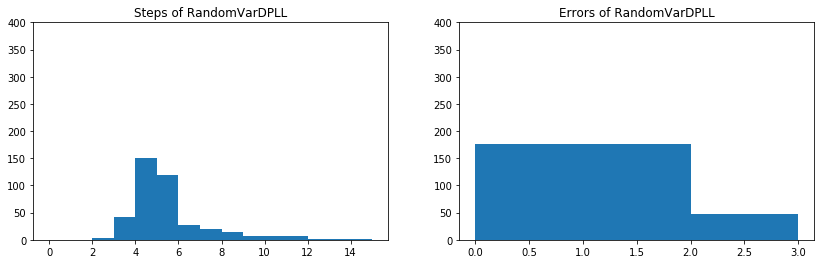

#Sats: 400; avg step: 4.10; stdev step: 1.42; avg error: 0.20; stdev error: 0.44


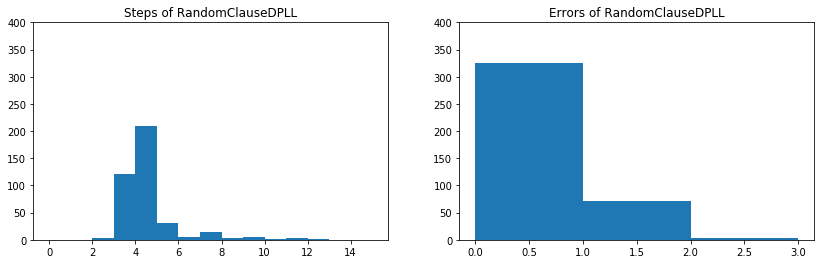

#Sats: 400; avg step: 3.72; stdev step: 0.46; avg error: 0.00; stdev error: 0.00


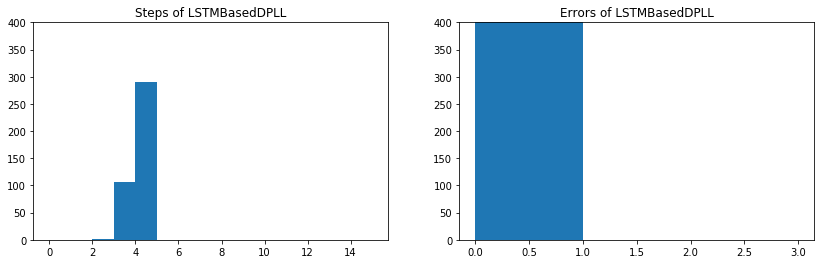

#Sats: 400; avg step: 3.41; stdev step: 0.83; avg error: 0.04; stdev error: 0.20


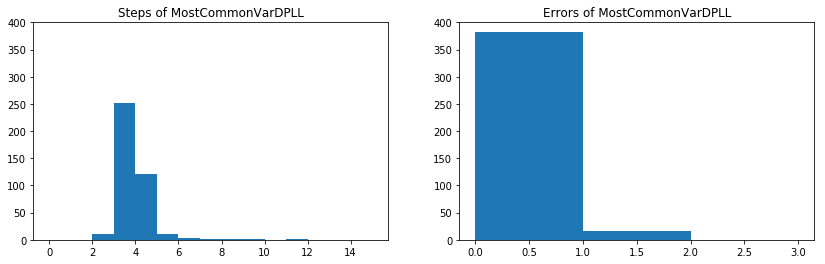

In [15]:
print_all(400, 3, 3, 6)

#Sats: 100; avg step: 9.51; stdev step: 4.17; avg error: 1.53; stdev error: 1.01


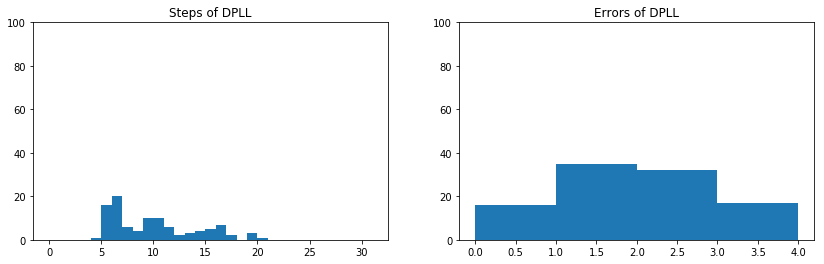

#Sats: 100; avg step: 9.65; stdev step: 4.20; avg error: 1.71; stdev error: 0.91


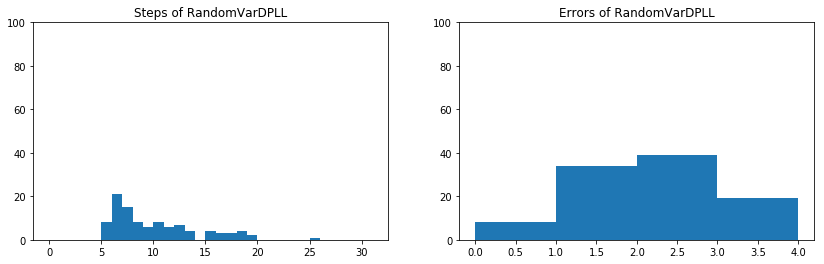

#Sats: 100; avg step: 7.56; stdev step: 3.33; avg error: 0.92; stdev error: 0.80


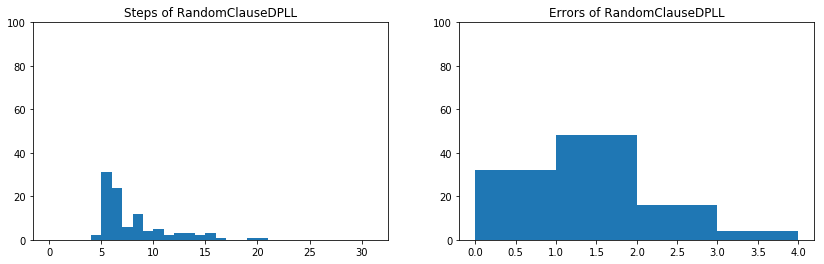

#Sats: 100; avg step: 4.96; stdev step: 0.20; avg error: 0.00; stdev error: 0.00


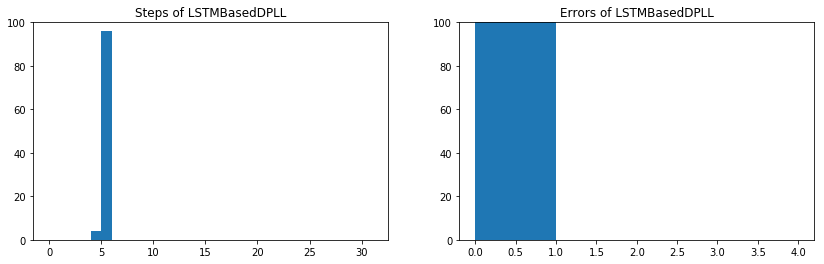

#Sats: 100; avg step: 5.46; stdev step: 1.90; avg error: 0.18; stdev error: 0.38


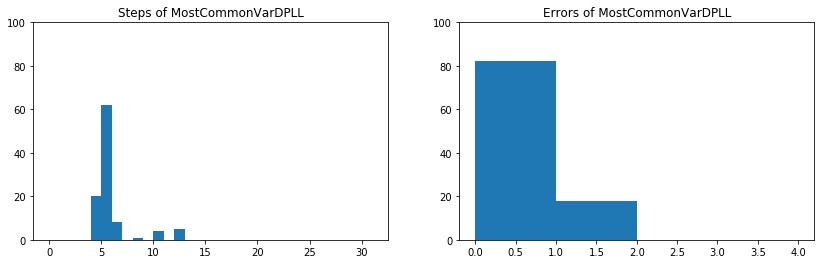

In [16]:
print_all(100, 3, 4, 20)

#Sats: 100; avg step: 10.25; stdev step: 3.82; avg error: 2.02; stdev error: 0.95


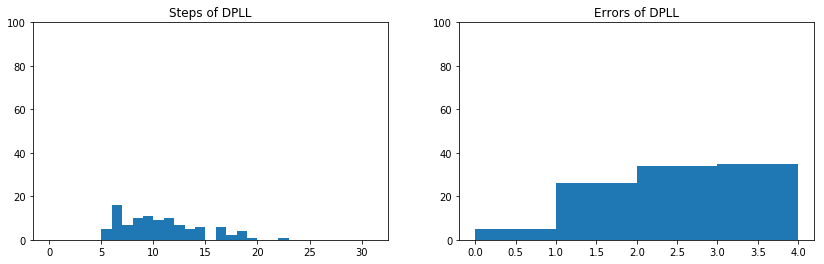

#Sats: 100; avg step: 10.15; stdev step: 4.02; avg error: 1.89; stdev error: 1.02


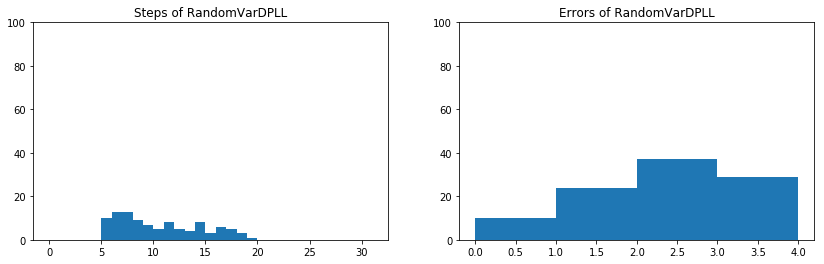

#Sats: 100; avg step: 8.61; stdev step: 3.48; avg error: 1.24; stdev error: 0.81


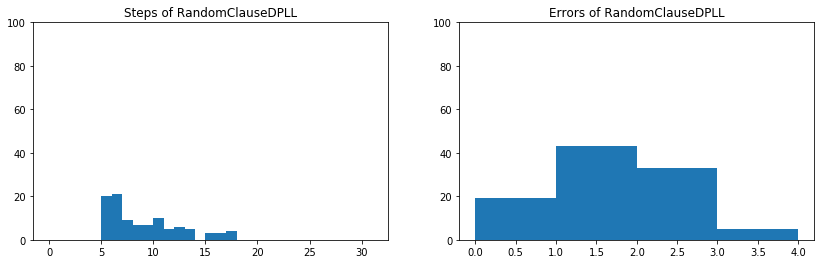

#Sats: 100; avg step: 4.99; stdev step: 0.10; avg error: 0.00; stdev error: 0.00


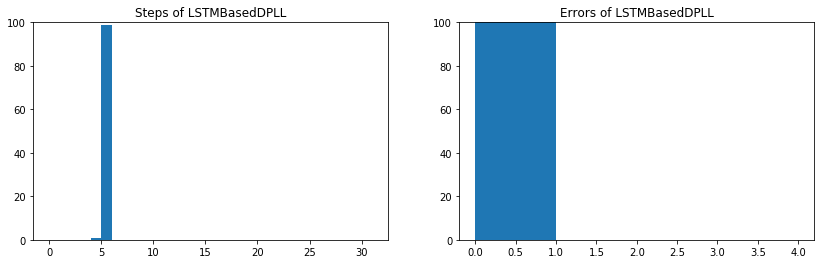

#Sats: 100; avg step: 6.00; stdev step: 2.23; avg error: 0.27; stdev error: 0.47


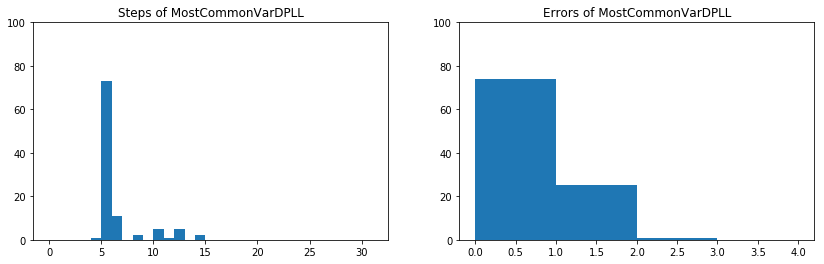

In [17]:
print_all(100, 3, 4, 40)

#Sats: 100; avg step: 9.25; stdev step: 3.20; avg error: 1.95; stdev error: 0.89


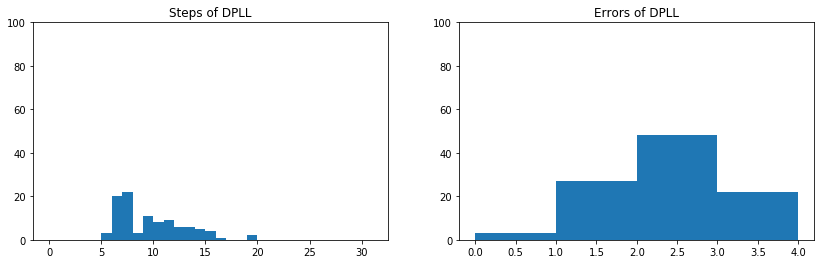

#Sats: 100; avg step: 9.09; stdev step: 3.48; avg error: 1.83; stdev error: 0.98


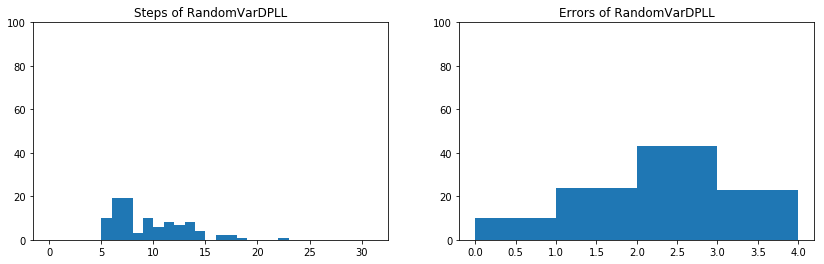

#Sats: 100; avg step: 7.69; stdev step: 3.01; avg error: 1.17; stdev error: 0.84


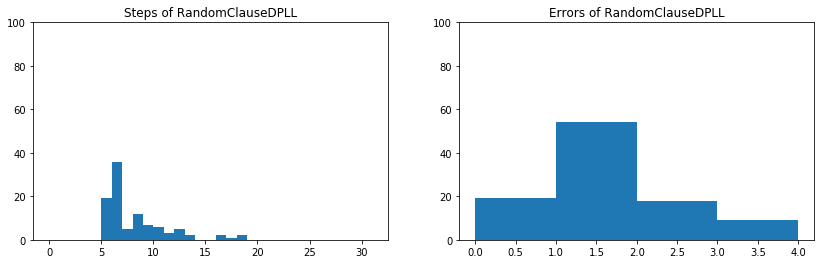

#Sats: 100; avg step: 5.05; stdev step: 0.50; avg error: 0.01; stdev error: 0.10


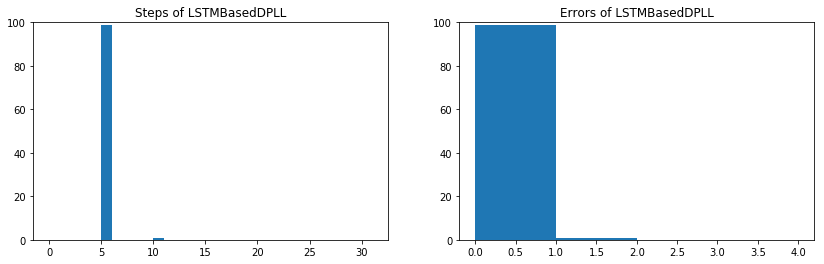

#Sats: 100; avg step: 6.02; stdev step: 2.14; avg error: 0.30; stdev error: 0.52


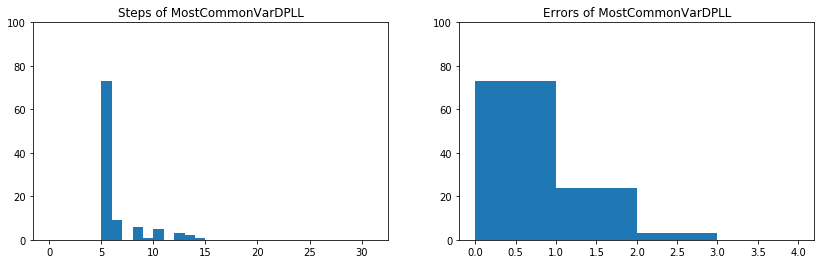

In [18]:
print_all(100, 3, 4, 50)

#Sats: 100; avg step: 8.58; stdev step: 2.54; avg error: 1.92; stdev error: 0.96


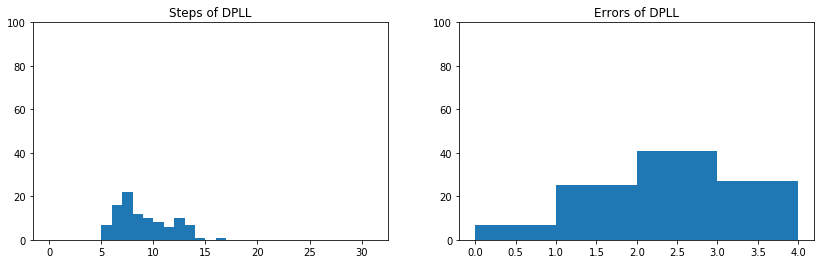

#Sats: 100; avg step: 8.98; stdev step: 2.73; avg error: 2.02; stdev error: 0.96


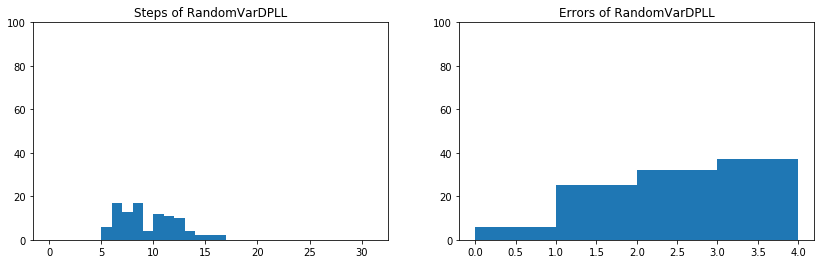

#Sats: 100; avg step: 8.17; stdev step: 2.64; avg error: 1.41; stdev error: 0.92


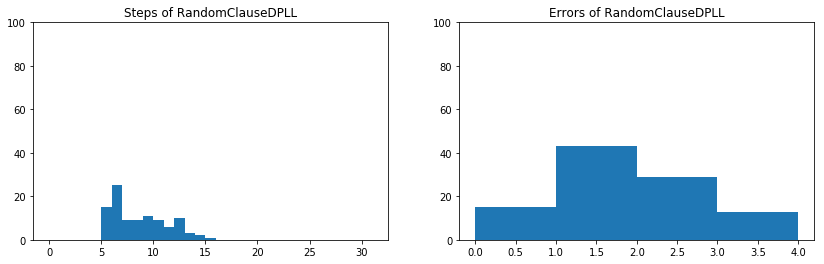

#Sats: 100; avg step: 5.01; stdev step: 0.10; avg error: 0.01; stdev error: 0.10


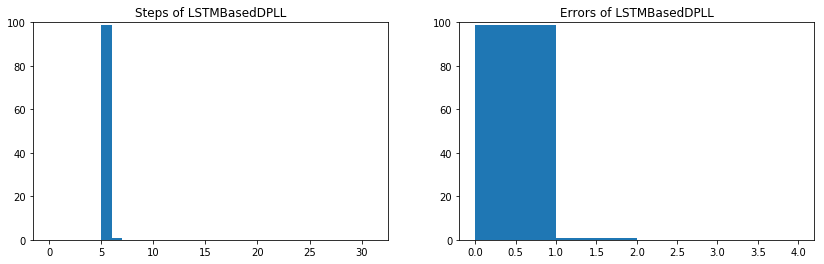

#Sats: 100; avg step: 5.20; stdev step: 0.82; avg error: 0.08; stdev error: 0.27


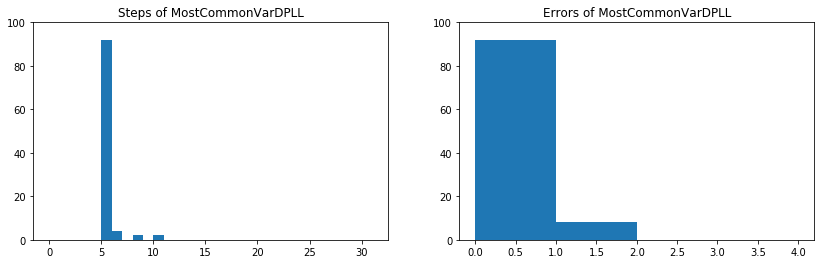

In [20]:
print_all(100, 3, 4, 70)

In [21]:
print_all(100, 3, 4, 80)

AssertionError: 

In [ ]:
print_all(100, 3, 4, 90)

In [ ]:
print_all(100, 3, 4, 100)

```
VARIABLE_NUM = 4
CLAUSE_SIZE = 3
CLAUSE_NUM = 20
EMBEDDING_SIZE = 64
LSTM_STATE_SIZE = 64
```

Generalises well from 20 clauses to 70!